In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix
from typing import Any

## Oxford - IIIT Pets dataset

In [9]:
dataset: Any
info: Any

dataset, info = tfds.load(name="oxford_iiit_pet:3.*.*", with_info=True)

Normalize colors values to [0, 1] and change the labels of the mask 

In [10]:
def normalize(input_image: Any, input_mask: Any) -> tuple[Any, Any]:
    input_image: Any = tf.cast(x=input_image, dtype=tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint: Any) -> tuple[Any, Any]:
    input_image: Any = tf.image.resize(images=datapoint["image"], size=(128, 128))
    input_mask = tf.image.resize(
        images=datapoint["segmentation_mask"],
        size=(128, 128),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )

    input_image, input_mask = normalize(input_image=input_image, input_mask=input_mask)

    return input_image, input_mask

## Parameters and constants

In [11]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PRE_EPOCH = TRAIN_LENGTH // BATCH_SIZE


Load the datasets

In [12]:
train_images: Any = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images:Any = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Image augmentation

In [13]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42) -> None:
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels) -> tuple[Any, Any]:
        inputs: Any = self.augment_inputs(inputs)
        labels: Any = self.augment_labels(labels)
        return inputs, labels

applying the augmentation after batching the inputs

In [14]:
train_batches: Any = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches: Any = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title: list[str] = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(label=title[i])
        plt.imshow(X=tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

Print some images

2023-05-28 23:47:11.112693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-05-28 23:47:11.114077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype resource
	 [[{{node Placeholder/_34}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


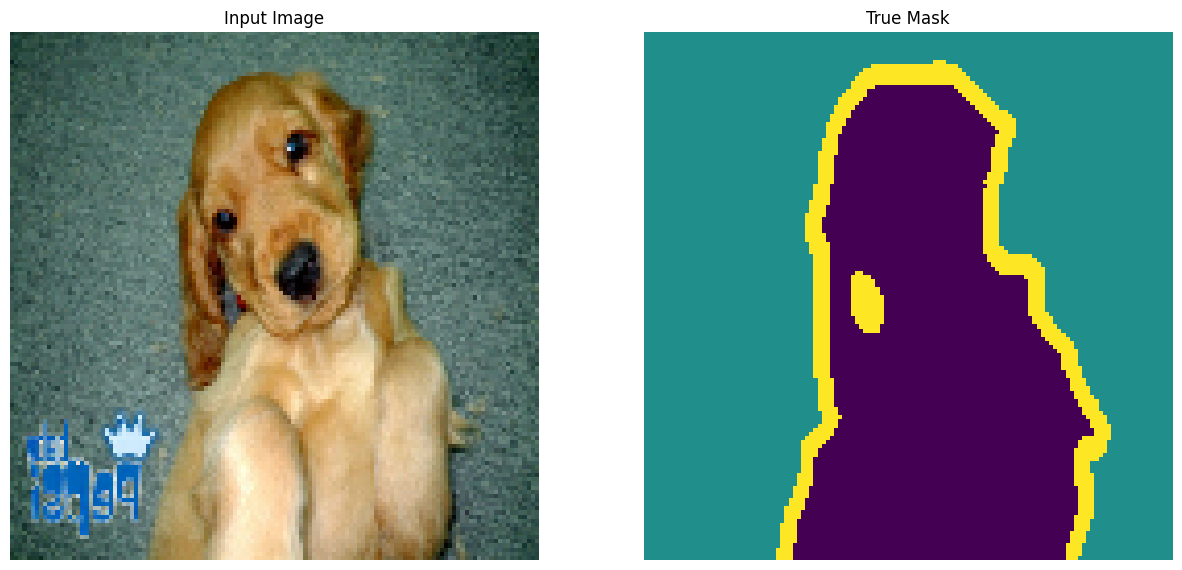

2023-05-28 23:47:12.189701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


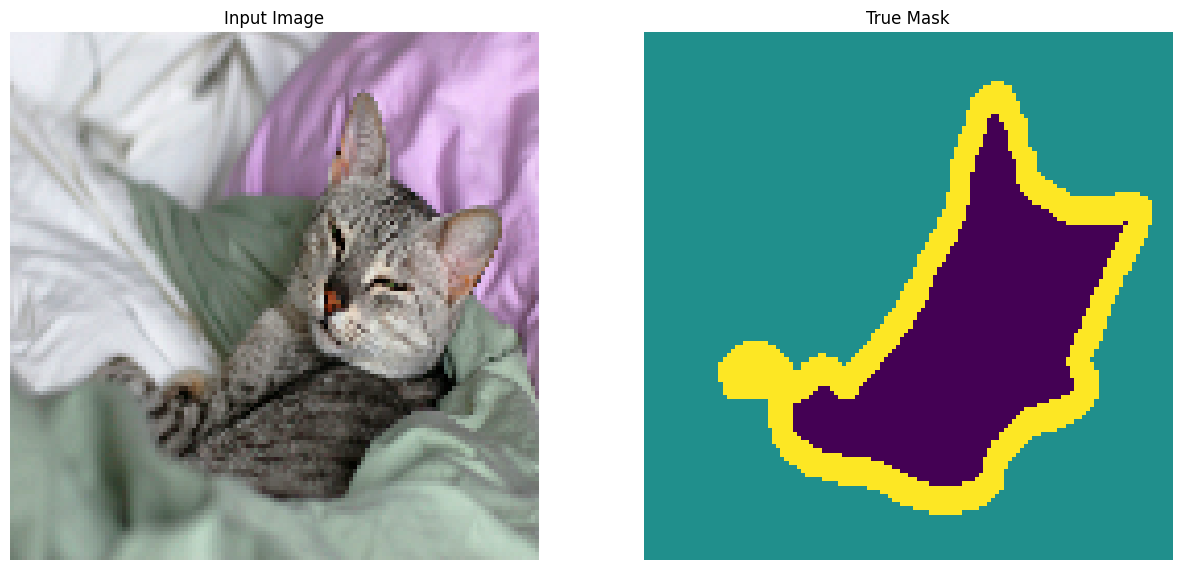

In [18]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display(display_list=[sample_image, sample_mask])